In [45]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fft
from scipy import signal as sig
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import matplotlib.pyplot as plt

In [46]:
def pickle_file(obj, path):
    file = open(path, 'wb')
    pickle.dump(obj, file)
    file.close()

def load_pickle(path):
    file = open(path, 'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [47]:
df = load_pickle('./data_merged/mta_station_broughs_cases')
df = df.groupby('DATE').sum().reset_index()
df['WEEK_YEAR']= pd.to_datetime(df["DATE"].dt.strftime('%Y-%m'))
df.head()

,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,ZIP_CODE,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,WEEK_YEAR
0,2017-12-30,2.857334e+06,2.312368e+06,2.808571e+06,4944907,0.0,0.0,0.0,0.0,2017-12-01
1,2017-12-31,2.435901e+06,2.013643e+06,2.445328e+06,4944907,0.0,0.0,0.0,0.0,2017-12-01
2,2018-01-01,1.898038e+06,1.579894e+06,1.914122e+06,4944907,0.0,0.0,0.0,0.0,2018-01-01
3,2018-01-02,5.046387e+06,3.826915e+06,4.837009e+06,4944907,0.0,0.0,0.0,0.0,2018-01-01
4,2018-01-03,5.531911e+06,4.154126e+06,5.271669e+06,4944907,0.0,0.0,0.0,0.0,2018-01-01


In [67]:
df = df[df.DATE >= '2020-04-01']
df['HOURS_ELAPSE'] = (df.DATE - pd.to_datetime('2020-04-01')).astype('timedelta64[h]')
df.DAILY_EXITS = df.LINE_DENSITY
df.head()

,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,ZIP_CODE,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,WEEK_YEAR,...,FT_124,FT_125,FT_126,FT_127,FT_128,FT_129,FT_130,FT_131,FT_132,FT_133
823,2020-04-01,534912.000000,667717.916703,667717.916703,4987108,2539234.0,809908.0,208302.0,2279206.0,2020-04-01,...,-2.139345e+05,4.788769e+06,4.099735e+06,5.113410e+06,1.392869e+06,4.618024e+06,4.243093e+06,3.679853e+06,2.721867e+05,2.586918e+06
824,2020-04-02,506228.000000,632185.166631,632185.166631,4987108,2677636.0,774492.0,231602.0,2325806.0,2020-04-01,...,-3.795155e+06,-5.083052e+06,-4.772257e+06,-3.664035e+06,2.439059e+06,-3.380563e+05,-3.244474e+05,-3.578169e+06,1.910369e+06,-2.584375e+06
825,2020-04-03,504269.000000,630868.788636,630868.788636,4987108,2642220.0,793598.0,232534.0,2362620.0,2020-04-01,...,6.043843e+06,5.316190e+06,4.240865e+05,8.775079e+05,-4.702865e+06,-4.755817e+06,-3.954272e+06,3.271734e+06,-3.246176e+06,2.581449e+06
826,2020-04-04,296085.453957,393522.517698,393522.517698,4998344,1805422.0,672947.0,238170.0,2393375.0,2020-04-01,...,-5.489064e+06,-5.485379e+06,4.370247e+06,2.229257e+06,3.943101e+06,-1.600434e+06,3.844511e+06,-2.778084e+06,3.143151e+06,-2.578138e+06
827,2020-04-05,240125.000000,325698.773737,325698.773737,4998344,1765260.0,651465.0,269926.0,2408319.0,2020-04-01,...,2.388154e+06,5.588584e+06,-4.566827e+06,-4.522477e+06,-6.482346e+05,4.103474e+06,5.319178e+05,2.125467e+06,-1.646961e+06,2.574444e+06


In [69]:


# time_sec is the hourly timestamp converted to seconds
X2 = pd.DataFrame(df[['HOURS_ELAPSE','HOSPITALIZED_COUNT']]) 
X1 = pd.DataFrame(df[['HOURS_ELAPSE']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(df.DAILY_EXITS) 

model1 = LinearRegression()
model1.fit(X1, y) 
df['pred_exits_linreg_date'] = model1.predict(X1)
df['residuals1'] = df.DAILY_EXITS - df.pred_exits_linreg_date

model2 = LinearRegression()
model2.fit(X2, y) 
df['pred_exits_linreg_date_hosp'] = model2.predict(X2)
df['residuals2'] = df.DAILY_EXITS - df.pred_exits_linreg_date_hosp

# time = data['time']
# residuals = data['residuals']

df.head()
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model1.coef_[0,0], model1.intercept_[0]))
print('R-squared: {:.2e}'.format(model1.score(X1,y)))

print('\n')
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model2.coef_[0,0], model2.intercept_[0]))
print('R-squared: {:.2e}'.format(model2.score(X2,y)))

Slope: 1.07e+02, Intercept: 913194.21
R-squared: 5.38e-01


Slope: 1.03e+02, Intercept: 1033407.57
R-squared: 5.66e-01


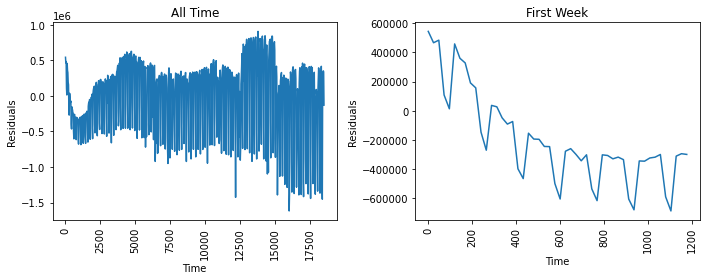

In [70]:
## Plot residuals in the time domain
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(df.HOURS_ELAPSE, df.residuals2, label='residuals')
ax1.set_title('All Time')
ax1.set_ylabel( 'Residuals' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 50

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(df.HOURS_ELAPSE[:N], df.residuals2[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Residuals' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

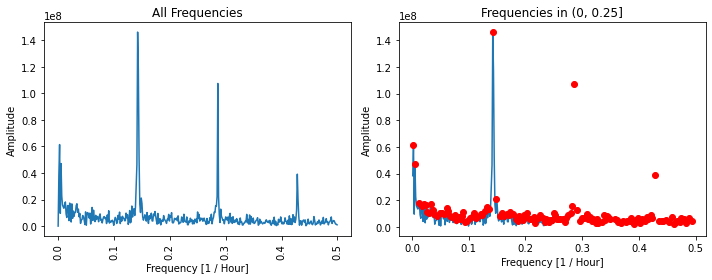

In [71]:
time = df.HOURS_ELAPSE
residuals = np.array(df.residuals2)

# Plotting power in the frequency domain
fft_output = fft.fft(residuals)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='residuals')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**4)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()

In [72]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq 
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)
output

,index,freq (1/hour),amplitude,period (days),fft
37,110,0.142303,1.461293e+08,7.027273,1.168700e+07+1.456612e+08j
77,221,0.285899,1.074262e+08,3.497738,-7.257795e+07+7.920120e+07j
0,2,0.002587,6.140200e+07,386.500000,-6.037538e+07-1.118118e+07j
1,4,0.005175,4.712516e+07,193.250000,4.542100e+07+1.255840e+07j
116,331,0.428202,3.912157e+07,2.335347,3.377945e+07+1.973439e+07j
...,...,...,...,...,...
99,285,0.368693,2.875787e+06,2.712281,7.872349e+05-2.765938e+06j
87,250,0.323415,2.858773e+06,3.092000,2.727763e+06-8.555083e+05j
56,168,0.217335,2.812820e+06,4.601190,2.689993e+06+8.221295e+05j
106,303,0.391979,2.078334e+06,2.551155,1.586070e+05-2.072273e+06j


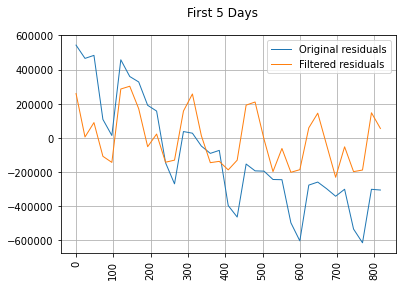

In [73]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_residuals = fft.ifft(filtered_fft_output)

N = 35
plt.plot(time[:N], residuals[:N], linewidth=1, label='Original residuals')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
# plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [74]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq (1 / hour)'] = output['freq (1/hour)']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq (1 / hour),amplitude,phase
label,,,,
FT_1,1.168700e+07+1.456612e+08j,0.142303,1.461293e+08,1.490734
FT_2,-7.257795e+07+7.920120e+07j,0.285899,1.074262e+08,2.312585
FT_3,-6.037538e+07-1.118118e+07j,0.002587,6.140200e+07,-2.958473
FT_4,4.542100e+07+1.255840e+07j,0.005175,4.712516e+07,0.269750
FT_5,3.377945e+07+1.973439e+07j,0.428202,3.912157e+07,0.528730
...,...,...,...,...
FT_128,7.872349e+05-2.765938e+06j,0.368693,2.875787e+06,-1.293511
FT_129,2.727763e+06-8.555083e+05j,0.323415,2.858773e+06,-0.303914
FT_130,2.689993e+06+8.221295e+05j,0.217335,2.812820e+06,0.296609


In [75]:
def ft_function(df):
    data = df
    for key in fourier_terms_dict.keys():
        a = fourier_terms_dict[key]['amplitude']
        w = 2 * math.pi * (fourier_terms_dict[key]['freq (1 / hour)'] / 24)
        p = fourier_terms_dict[key]['phase']
        data[key] = data.HOURS_ELAPSE.apply(lambda t: a * math.cos(w*t + p))

    data['FT_All'] = 0
    for column in list(fourier_terms.index):
        data['FT_All'] = data['FT_All'] + data[column]


    # Sample 
    data[['DAILY_EXITS', 'HOURS_ELAPSE', 'FT_All']  + list(fourier_terms.index)]
    return data

data = ft_function(df)
data

,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,ZIP_CODE,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,WEEK_YEAR,...,FT_124,FT_125,FT_126,FT_127,FT_128,FT_129,FT_130,FT_131,FT_132,FT_133
823,2020-04-01,5.349120e+05,6.677179e+05,6.677179e+05,4987108,2539234.0,809908.0,208302.0,2279206.0,2020-04-01,...,-2.925353e+06,2.594170e+06,2.708760e+06,2.878604e+06,7.872349e+05,2.727763e+06,2.689993e+06,1.586070e+05,1.953401e+06,2.586918e+06
824,2020-04-02,5.062280e+05,6.321852e+05,6.321852e+05,4987108,2677636.0,774492.0,231602.0,2325806.0,2020-04-01,...,3.239671e+06,-2.958096e+06,-2.872679e+06,-2.064512e+06,1.497588e+06,-4.480240e+05,-2.566488e+05,1.177501e+06,-1.859988e+06,-2.584375e+06
825,2020-04-03,5.042690e+05,6.308688e+05,6.308688e+05,4987108,2642220.0,793598.0,232534.0,2362620.0,2020-04-01,...,-3.392791e+06,2.099327e+05,3.002042e+06,4.969963e+05,-2.819580e+06,-2.328935e+06,-2.794604e+06,-1.991695e+06,1.660144e+06,2.581449e+06
826,2020-04-04,2.960855e+05,3.935225e+05,3.935225e+05,4998344,1805422.0,672947.0,238170.0,2393375.0,2020-04-01,...,3.377095e+06,2.759092e+06,-3.095293e+06,1.251893e+06,2.328805e+06,2.521224e+06,-8.824429e+05,1.923093e+06,-1.365303e+06,-2.578138e+06
827,2020-04-05,2.401250e+05,3.256988e+05,3.256988e+05,4998344,1765260.0,651465.0,269926.0,2408319.0,2020-04-01,...,-3.193363e+06,-2.825391e+06,3.151311e+06,-2.543916e+06,-3.407932e+05,8.456015e+04,2.434917e+06,-1.002101e+06,9.923361e+05,2.574444e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,2022-05-09,2.324741e+06,3.047563e+06,3.047563e+06,4998344,0.0,0.0,0.0,0.0,2022-05-01,...,-2.892826e+05,-3.151736e+06,-1.452935e+06,2.834247e+06,2.738722e+06,-1.448337e+06,2.726772e+06,6.702568e+05,-8.569835e+05,-2.593857e+06
1592,2022-05-10,2.497367e+06,3.270883e+06,3.270883e+06,4998344,0.0,0.0,0.0,0.0,2022-05-01,...,-4.704054e+05,7.840280e+05,1.752669e+06,-1.907857e+06,-1.213940e+06,-1.562476e+06,1.231648e+06,7.133346e+05,1.251042e+06,2.593240e+06
1593,2022-05-11,2.519619e+06,3.298330e+06,3.298330e+06,4998344,0.0,0.0,0.0,0.0,2022-05-01,...,1.206687e+06,2.408523e+06,-2.031319e+06,2.852135e+05,-1.091309e+06,2.839241e+06,-2.224747e+06,-1.780749e+06,-1.573512e+06,-2.592237e+06
1594,2022-05-12,2.507500e+06,3.285971e+06,3.285971e+06,4998344,0.0,0.0,0.0,0.0,2022-05-01,...,-1.882927e+06,-3.067168e+06,2.285535e+06,1.441516e+06,2.694932e+06,-9.649949e+05,-2.138463e+06,2.058866e+06,1.805944e+06,2.590849e+06


In [76]:
# time_sec is the hourly timestamp converted to seconds
# list(fourier_terms.index) are the names of our Fourier terms
# X = pd.DataFrame(data[['time_sec'] + list(fourier_terms.index)]) 
X = pd.DataFrame(data[['HOURS_ELAPSE', 'FT_All', 'HOSPITALIZED_COUNT']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(data['DAILY_EXITS']) 

model = LinearRegression()
model.fit(X, y)

df['y_pred'] = model.predict(X)

df.head()
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model1.coef_[0,0], model1.intercept_[0]))
print('R-squared: {:.2e}'.format(model1.score(X1,y)))

print('\n')
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model2.coef_[0,0], model2.intercept_[0]))
print('R-squared: {:.2e}'.format(model2.score(X2,y)))

print('\n')
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(X,y)))

df.head()
# N = 7 * 10

# plt.plot(X['HOURS_ELAPSE'][:N], y[:N], linewidth=1, label='Original Signal')
# plt.plot(X['HOURS_ELAPSE'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
# plt.legend(loc='upper right')
# plt.suptitle('First 5 Days')
# plt.grid()
# plt.xticks(rotation=90)

Slope: 1.07e+02, Intercept: 913194.21
R-squared: 5.38e-01


Slope: 1.03e+02, Intercept: 1033407.57
R-squared: 5.66e-01


Slope: 1.05e+02, Intercept: 1019992.11
R-squared: 8.36e-01


,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,ZIP_CODE,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,WEEK_YEAR,...,FT_124,FT_125,FT_126,FT_127,FT_128,FT_129,FT_130,FT_131,FT_132,FT_133
823,2020-04-01,534912.000000,667717.916703,667717.916703,4987108,2539234.0,809908.0,208302.0,2279206.0,2020-04-01,...,-2.925353e+06,2.594170e+06,2.708760e+06,2.878604e+06,7.872349e+05,2.727763e+06,2.689993e+06,1.586070e+05,1.953401e+06,2.586918e+06
824,2020-04-02,506228.000000,632185.166631,632185.166631,4987108,2677636.0,774492.0,231602.0,2325806.0,2020-04-01,...,3.239671e+06,-2.958096e+06,-2.872679e+06,-2.064512e+06,1.497588e+06,-4.480240e+05,-2.566488e+05,1.177501e+06,-1.859988e+06,-2.584375e+06
825,2020-04-03,504269.000000,630868.788636,630868.788636,4987108,2642220.0,793598.0,232534.0,2362620.0,2020-04-01,...,-3.392791e+06,2.099327e+05,3.002042e+06,4.969963e+05,-2.819580e+06,-2.328935e+06,-2.794604e+06,-1.991695e+06,1.660144e+06,2.581449e+06
826,2020-04-04,296085.453957,393522.517698,393522.517698,4998344,1805422.0,672947.0,238170.0,2393375.0,2020-04-01,...,3.377095e+06,2.759092e+06,-3.095293e+06,1.251893e+06,2.328805e+06,2.521224e+06,-8.824429e+05,1.923093e+06,-1.365303e+06,-2.578138e+06
827,2020-04-05,240125.000000,325698.773737,325698.773737,4998344,1765260.0,651465.0,269926.0,2408319.0,2020-04-01,...,-3.193363e+06,-2.825391e+06,3.151311e+06,-2.543916e+06,-3.407932e+05,8.456015e+04,2.434917e+06,-1.002101e+06,9.923361e+05,2.574444e+06


In [299]:
def generate_figure(df, columns):
    # df = df[df.DATE.dt.weekday > 4]
    df = df.groupby('WEEK_YEAR').mean().reset_index()
    df['DATE'] = df.WEEK_YEAR
    # df = df[df.TIME_OF_WEEK == 'Weekend']
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    #               yaxis_domain=[0, 0.94])

    fig.add_trace(go.Scatter(x=df.DATE, y=df.HOSP_COUNT_7DAY_AVG,
                        mode='lines',
                        name='Hospitalized',
                        opacity = .8))
    for col in columns:
        fig.add_trace(go.Scatter(x=df.DATE, y=df[col],
                            mode='lines',
                            name=borough_dict[col.split('_')[0]],
                            opacity = .35),
                            secondary_y = True)
    # fig.data[1].update(xaxis='x2')
    fig.update_yaxes(title_text="Hospitalized", secondary_y=False)
    fig.update_yaxes(title_text="Subway Traffic", secondary_y=True)
    fig.update_layout(title='Average Weekly Subway Use and Rates of Covid Hospitalization')
    
    return fig
fig = generate_figure(df, ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY','Q_LINE_DENSITY'])
fig.write_html("./images/Weekly_Subway_Use_By_Borough.html")
fig.show()
# generate_figure(df, ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'Q_LINE_DENSITY']).show()

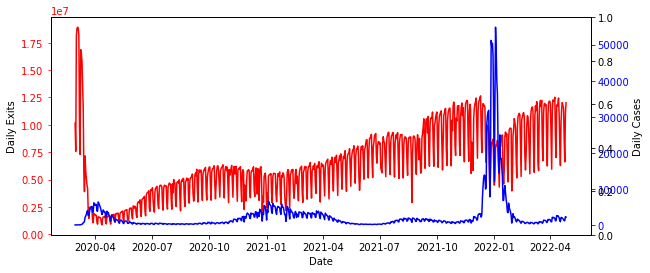

In [300]:

# plt.figure(figsize=(4,12))

fig, ax = plt.subplots(figsize=(12,4))


# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
# axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Red', 'Blue')
i=0
# df = df[df.DAILY_ENTRIES<1000000]
for ax, color in zip(axes, colors):
    if i ==0 :
        ax.plot(df.DATE,df.DAILY_EXITS, color=color)
        ax.set_ylabel('Daily Exits')
    else: 
        ax.plot(df.DATE,df.CASE_COUNT, color=color)
        ax.set_ylabel('Daily Cases')
    # ax.set_ylabel('%s Thing' % color, color=color)
    ax.tick_params(axis='y', colors=color)
    i+= 1
axes[0].set_xlabel('Date')


plt.show()

In [21]:
# df1 = df.melt(id_vars=['DATE']+list(df.keys()[5:]), var_name='Subway')
df['DAY_OF_WEEK'] = df.DATE.dt.day_name()
df['TIME_OF_WEEK'] = df.DATE.dt.weekday.replace([0,1,2,3,4],'Weekday').replace([5,6],'Weekend')
fig = px.line(df, x='DATE', y='DAILY_EXITS', color='TIME_OF_WEEK' )
# fig.add_trace()
fig.show()

In [66]:
# Create traces
# fig = go.Figure()

def generate_figure(df):
    # df = df[df.TIME_OF_WEEK == 'Weekend']
    fig = make_subplots(
                        # cols=1,
                        # rows=4,
                        # specs=[[{}, {}],[{"colspan": 2}, None]]
                        )
    
    # fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    #               yaxis_domain=[0, 0.94])
    

    fig.add_trace(go.Scatter(x=df.DATE, y=df.pred_exits_linreg_date_hosp,
                        mode='lines',
                        # name='Prediction (Date, Hospitalized)',
                        opacity = .8,
                        line=dict(width=1),
                        legendgroup="1",  # this can be any string, not just "group"
                        legendgrouptitle_text="Prediction (R-squared: 6.94e-01)",
                        name="Date, Hospitalized"),
                        # row = 1,
                        # col = 1
                        )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.pred_exits_linreg_date,
                        mode='lines',
                        # name='Prediction (Date)',
                        opacity = .8,
                        line=dict(width=1),
                        legendgroup="2",  # this can be any string, not just "group"
                        legendgrouptitle_text="Prediction (R-squared: 7.24e-01)",
                        name="Date"),
                        # row = 2,
                        # col = 1
                        )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.y_pred,
                        mode='lines',
                        # name='Prediction (Date, Hospitalized, Fourier)',
                        opacity = .8,
                        line=dict(width=1),
                        legendgroup="3",  # this can be any string, not just "group"
                        legendgrouptitle_text="Prediction (R-squared: 9.48e-01)",
                        name="Date, Hospitalized, Fourier"),
                        # row = 3,
                        # col = 1
                        )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.DAILY_EXITS,
                        mode='lines',
                        # name='Actual',
                        opacity = .4,
                        line=dict(color='firebrick', width=1),
                        legendgroup="4",  # this can be any string, not just "group"
                        legendgrouptitle_text="Actual Subway Traffic",
                        name="Ground-Truth"),
                        # row = 4,
                        # col = 1
                        )

    # fig.data[1].update(xaxis='x2')
    # fig.update_yaxes(title_text="Predicted")
    # fig.update_yaxes(title_text="Actual")
    # fig.update_layout(legend_title_text='Subway Use')
    fig.update_layout(title='Predicting Subway Use Post New York City Stay At Home Order')
    # fig.write_html("./images/subway_use_regression_date_hosp_with_fourier.html")
    
    return fig
generate_figure(df).show()

In [8]:
df.columns

Index(['DATE', 'DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY',
       'Bk_DAILY_ENTRIES', 'Bx_DAILY_ENTRIES', 'M_DAILY_ENTRIES',
       'Q_DAILY_ENTRIES', 'SI_DAILY_ENTRIES', 'Bk_DAILY_EXITS',
       'Bx_DAILY_EXITS', 'M_DAILY_EXITS', 'Q_DAILY_EXITS', 'SI_DAILY_EXITS',
       'Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY',
       'Q_LINE_DENSITY', 'SI_LINE_DENSITY', 'DATE_OF_INTEREST', 'CASE_COUNT',
       'probable_case_count', 'HOSPITALIZED_COUNT', 'DEATH_COUNT',
       'DEATH_COUNT_PROBABLE', 'CASE_COUNT_7DAY_AVG',
       'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
       'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg'],
      dtype='object')

In [15]:

def generate_corr_table(full_df):
    corr_table = []
    rows = ['DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY']
    columns = ['CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT', 
        'CASE_COUNT_7DAY_AVG', 'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
        'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg']
    masks = ['Daily', 'Weekday', 'Weekend']

    full_df['TIME_OF_WEEK'] = full_df.DATE.dt.weekday.replace([0,1,2,3,4],'Weekday').replace([5,6],'Weekend')
    for mask in masks:
        if mask == 'Weekday':
            df = full_df[full_df.TIME_OF_WEEK == 'Weekday']
        elif mask == 'Weekend':
            df = full_df[full_df.TIME_OF_WEEK == 'Weekend']
        else:
            df = full_df
        for row in rows:
            dict_to_add = {'Mask':mask ,'Correlate':row}
            for column in columns:
                dict_to_add[column] = df[row].corr(df[column])
            corr_table.append(dict_to_add)
    return corr_table

def generate_corr_table_2(full_df):
    corr_table = []
    # rows = ['DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY']
    rows = ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY',
       'Q_LINE_DENSITY', 'SI_LINE_DENSITY']
    columns = ['CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT', 
        'CASE_COUNT_7DAY_AVG', 'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
        'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg']

    df = full_df
    for row in rows:
        dict_to_add = {'Correlate':row}
        for column in columns:
            dict_to_add[column] = df[row].corr(df[column])
        corr_table.append(dict_to_add)
    return corr_table
corr_table = pd.DataFrame(generate_corr_table_2(df))
# corr_table.to_csv('./tables/correlation_table_time_of_week.csv')
corr_table.head()


,Correlate,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg
0,Bk_LINE_DENSITY,0.029814,-0.301112,-0.412242,-0.043991,-0.036477,-0.343780,-0.418453,-0.409800
1,Bx_LINE_DENSITY,0.024843,-0.267438,-0.380951,-0.063265,-0.055679,-0.320002,-0.388803,-0.381172
2,M_LINE_DENSITY,0.041330,-0.289087,-0.388085,-0.022554,-0.016779,-0.326264,-0.392899,-0.381997
3,Q_LINE_DENSITY,0.048379,-0.309094,-0.438308,-0.028372,-0.019813,-0.355223,-0.445171,-0.435980
4,SI_LINE_DENSITY,0.047977,-0.187201,-0.277484,-0.033027,-0.029996,-0.233598,-0.284945,-0.276426


In [121]:
# corr_table.groupby(['Mask']).max()
corr_table = corr_table.round(3)
corr_table.set_index(['Correlate'], inplace=True)

# corr_table.to_markdown('./tables/correlation_table_time_of_week.md')
corr_table.head()

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg
Correlate,,,,,,,,
DAILY_ENTRIES,0.019,-0.287,-0.392,-0.055,-0.049,-0.332,-0.399,-0.388
DAILY_EXITS,0.052,-0.305,-0.414,-0.013,-0.006,-0.342,-0.418,-0.409
LINE_DENSITY,0.035,-0.299,-0.408,-0.037,-0.030,-0.341,-0.414,-0.404


In [74]:
corr_table.abs().sort_values(('Daily', 'LINE_DENSITY'),axis=1, ascending=False)

DEATH_COUNT_7DAY_AVG  DEATH_COUNT  \
Mask    Correlate                                          
Daily   DAILY_ENTRIES                 0.399        0.392   
        DAILY_EXITS                   0.418        0.414   
        LINE_DENSITY                  0.414        0.408   
Weekday DAILY_ENTRIES                 0.463        0.458   
        DAILY_EXITS                   0.466        0.463   
        LINE_DENSITY                  0.478        0.474   
Weekend DAILY_ENTRIES                 0.488        0.481   
        DAILY_EXITS                   0.472        0.468   
        LINE_DENSITY                  0.497        0.492   

                       all_death_count_7day_avg  HOSP_COUNT_7DAY_AVG  \
Mask    Correlate                                                      
Daily   DAILY_ENTRIES                     0.388                0.332   
        DAILY_EXITS                       0.409                0.342   
        LINE_DENSITY                      0.404                0.341   
Weekday DAILY_ENTRIES                     0.451                0.382   
        DAILY_EXITS                       0.456                0.378   
        LINE_DENSITY                      0.467                0.391   
Weekend DAILY_ENTRIES                     0.473                0.421   
        DAILY_EXITS                       0.459                0.397   
        LINE_DENSITY                      0.483                0.424   

                       HOSPITALIZED_COUNT  CASE_COUNT_7DAY_AVG  CASE_COUNT  \
Mask    Correlate                                                            
Daily   DAILY_ENTRIES               0.287                0.055       0.019   
        DAILY_EXITS                 0.305                0.013       0.052   
        LINE_DENSITY                0.299                0.037       0.035   
Weekday DAILY_ENTRIES               0.357                0.056       0.028   
        DAILY_EXITS                 0.361                0.007       0.017   
        LINE_DENSITY                0.370                0.034       0.009   
Weekend DAILY_ENTRIES               0.382                0.110       0.088   
        DAILY_EXITS                 0.368                0.046       0.036   
        LINE_DENSITY                0.390                0.082       0.067   

                       all_case_count_7day_avg  
Mask    Correlate                               
Daily   DAILY_ENTRIES                    0.049  
        DAILY_EXITS                      0.006  
        LINE_DENSITY                     0.030  
Weekday DAILY_ENTRIES                    0.048  
        DAILY_EXITS                      0.001  
        LINE_DENSITY                     0.027  
Weekend DAILY_ENTRIES                    0.101  
        DAILY_EXITS                      0.037  
        LINE_DENSITY                     0.073

In [29]:
print(f'Correlation between Subway Entries and Covid Cases:\t{df.DAILY_ENTRIES.corr(df.HOSP_COUNT_7DAY_AVG)}')
print(f'Correlation between Subway Exits and Covid Cases:\t{df.DAILY_EXITS.corr(df.HOSP_COUNT_7DAY_AVG)}')
print(f'Correlation between Line Density and Covid Cases:\t{df.LINE_DENSITY.corr(df.HOSP_COUNT_7DAY_AVG)}')

Correlation between Subway Entries and Covid Cases:	-0.4210110108217203
Correlation between Subway Exits and Covid Cases:	-0.3974747024305076
Correlation between Line Density and Covid Cases:	-0.42385720942325505


In [22]:
df = df[df.TIME_OF_WEEK == 'Weekend']

In [27]:
for x in range(-14,0):
    print(f'Correlation between Line Density and Covid Cases {-x} days later:\t{df.DAILY_EXITS.shift(x).corr(df.CASE_COUNT.iloc[:x])}')

Correlation between Line Density and Covid Cases 14 days later:	0.0770438946965025
Correlation between Line Density and Covid Cases 13 days later:	0.11008927080244933
Correlation between Line Density and Covid Cases 12 days later:	0.04216675584115764
Correlation between Line Density and Covid Cases 11 days later:	0.08459921553077798
Correlation between Line Density and Covid Cases 10 days later:	0.0277357720267018
Correlation between Line Density and Covid Cases 9 days later:	0.030059785495632107
Correlation between Line Density and Covid Cases 8 days later:	-0.008630599965366697
Correlation between Line Density and Covid Cases 7 days later:	-0.020227781505678662
Correlation between Line Density and Covid Cases 6 days later:	-0.03774931143740905
Correlation between Line Density and Covid Cases 5 days later:	-0.013752864111256443
Correlation between Line Density and Covid Cases 4 days later:	-0.05333670330824325
Correlation between Line Density and Covid Cases 3 days later:	-0.032622742

In [28]:
for x in range(1,14):
    print(f'Correlation between Line Density and Covid Cases {x} days before:\t{df.DAILY_EXITS.shift(x).corr(df.CASE_COUNT.iloc[x:])}')

Correlation between Line Density and Covid Cases 1 days before:	-0.0480335391831696
Correlation between Line Density and Covid Cases 2 days before:	0.015330823119700736
Correlation between Line Density and Covid Cases 3 days before:	0.029487996940136263
Correlation between Line Density and Covid Cases 4 days before:	0.10747593897455375
Correlation between Line Density and Covid Cases 5 days before:	0.16931407953418942
Correlation between Line Density and Covid Cases 6 days before:	0.20012947705495013
Correlation between Line Density and Covid Cases 7 days before:	0.266882193491665
Correlation between Line Density and Covid Cases 8 days before:	0.25096780051565964
Correlation between Line Density and Covid Cases 9 days before:	0.3011945318840952
Correlation between Line Density and Covid Cases 10 days before:	0.26757720711799177
Correlation between Line Density and Covid Cases 11 days before:	0.30726681310921167
Correlation between Line Density and Covid Cases 12 days before:	0.27786402